# Adam算法
:label:`sec_adam`

本章我们已经学习了许多有效优化的技术。
在本节讨论之前，我们先详细回顾一下这些技术：

* 在 :numref:`sec_sgd`中，我们学习了：随机梯度下降在解决优化问题时比梯度下降更有效。
* 在 :numref:`sec_minibatch_sgd`中，我们学习了：在一个小批量中使用更大的观测值集，可以通过向量化提供额外效率。这是高效的多机、多GPU和整体并行处理的关键。
* 在 :numref:`sec_momentum`中我们添加了一种机制，用于汇总过去梯度的历史以加速收敛。
* 在 :numref:`sec_adagrad`中，我们通过对每个坐标缩放来实现高效计算的预处理器。
* 在 :numref:`sec_rmsprop`中，我们通过学习率的调整来分离每个坐标的缩放。

Adam算法 :cite:`Kingma.Ba.2014`将所有这些技术汇总到一个高效的学习算法中。
不出预料，作为深度学习中使用的更强大和有效的优化算法之一，它非常受欢迎。
但是它并非没有问题，尤其是 :cite:`Reddi.Kale.Kumar.2019`表明，有时Adam算法可能由于方差控制不良而发散。
在完善工作中， :cite:`Zaheer.Reddi.Sachan.ea.2018`给Adam算法提供了一个称为Yogi的热补丁来解决这些问题。
下面我们了解一下Adam算法。

## 算法

Adam算法的关键组成部分之一是：它使用指数加权移动平均值来估算梯度的动量和二次矩，即它使用状态变量

$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}$$

这里$\beta_1$和$\beta_2$是非负加权参数。
常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
也就是说，方差估计的移动远远慢于动量估计的移动。
注意，如果我们初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
我们可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
相应地，标准化状态变量由下式获得

$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.$$

有了正确的估计，我们现在可以写出更新方程。
首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得

$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.$$

与RMSProp不同，我们的更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身。
此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
前者在实践中效果略好一些，因此与RMSProp算法有所区分。
通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。

最后，我们简单更新：

$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.$$

回顾Adam算法，它的设计灵感很清楚：
首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
其次，RMSProp算法中两项的组合都非常简单。
最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

## 实现

从头开始实现Adam算法并不难。
为方便起见，我们将时间步$t$存储在`hyperparams`字典中。
除此之外，一切都很简单。


In [8]:
import sys
sys.path.append("../")

In [9]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [10]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

<img src="./screen/limu%20%E4%BC%98%E5%8C%96%E7%AE%97%E6%B3%9512.png" alt="limu 优化算法12" style="zoom:33%;" />
<img src="./screen/limu%20%E4%BC%98%E5%8C%96%E7%AE%97%E6%B3%9513.png" alt="limu 优化算法12" style="zoom:33%;" />

In [11]:
def adam(params, states, hyperparams):
    # v的权重,s的权重,防止除数为0的值
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # [:]是为了原地赋值,节省内存
            # v = beta1 * v + (1 - beta1) * 新grad
            v[:] = beta1 * v + (1 - beta1) * p.grad
            # s = beta2 * s + (1 - beta2) * square(新grad)
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad) # square 平方
            # v_hat = v / (1 - beta1 ** t)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            # s_hat = s / (1 - beta2 ** t)
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            # p = p - lr * (v_hat / sqrt(s_hat) + eps)
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    # t每次都更新
    hyperparams['t'] += 1

现在，我们用以上Adam算法来训练模型，这里我们使用$\eta = 0.01$的学习率。


loss: 0.246, 0.013 sec/epoch


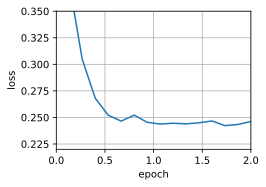

In [12]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

此外，我们可以用深度学习框架自带算法应用Adam算法，这里我们只需要传递配置参数。


loss: 0.242, 0.011 sec/epoch


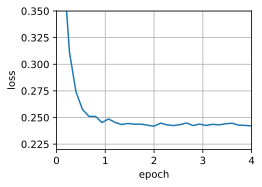

In [13]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Yogi

Adam算法也存在一些问题：
即使在凸环境下，当$\mathbf{s}_t$的二次矩估计值爆炸时，它可能无法收敛。
 :cite:`Zaheer.Reddi.Sachan.ea.2018`为$\mathbf{s}_t$提出了的改进更新和参数初始化。
论文中建议我们重写Adam算法更新如下：

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).$$

每当$\mathbf{g}_t^2$具有值很大的变量或更新很稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
这就是Yogi更新，现在更新的规模不再取决于偏差的量。

$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).$$

论文中，作者还进一步建议用更大的初始批量来初始化动量，而不仅仅是初始的逐点估计。


loss: 0.246, 0.013 sec/epoch


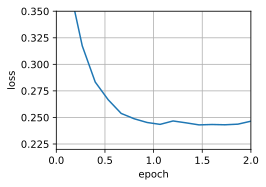

In [14]:
def yogi(params, states, hyperparams):
    # v的权重,s的权重,防止除数为0的值
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # [:]是为了原地赋值,节省内存
            # v = beta1 * v + (1 - beta1) * 新grad
            v[:] = beta1 * v + (1 - beta1) * p.grad
            # s = s + (1 - beta2) * sign(square(新grad) - s) * square(新grad)   change here!
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            # v_hat = v / (1 - beta1 ** t)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            # s_hat = s / (1 - beta2 ** t)
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            # p = p - lr * (v_hat / sqrt(s_hat) + eps)
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    # t每次都更新
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## 小结

* Adam算法将许多优化算法的功能结合到了相当强大的更新规则中。
* Adam算法在RMSProp算法基础上创建的，还在小批量的随机梯度上使用EWMA。
* 在估计动量和二次矩时，Adam算法使用偏差校正来调整缓慢的启动速度。
* 对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使用更大的小批量或者切换到改进的估计值$\mathbf{s}_t$来修正它们。Yogi提供了这样的替代方案。

## 练习

1. 调节学习率，观察并分析实验结果。
1. 试着重写动量和二次矩更新，从而使其不需要偏差校正。
1. 收敛时为什么需要降低学习率$\eta$？
1. 尝试构造一个使用Adam算法会发散而Yogi会收敛的例子。


[Discussions](https://discuss.d2l.ai/t/4331)
